In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [41]:
title = 'SARIMAX VCB 6-3-1'
train_ratio = 0.6
test_ratio = 0.3
#Mảng chứa giá trị để kiểm tra chu kỳ từ 2 đến 10 ngày (2 tuần)
seasonal_arr = np.array(range(2, 11))
seasonal_arr

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [42]:
df=pd.read_csv('../../VCB Historical Data.csv',index_col='Date',parse_dates=True)
#đảo ngược dữ liệu
df=df.iloc[::-1]

In [43]:
#Thêm tập dữ liệu VN Index
df_vni=pd.read_csv('../../VN Index Historical Data.csv',index_col='Date',parse_dates=True)
df_vni=df_vni.iloc[::-1]

In [44]:
df_vni=df_vni['Price'].replace(',','',regex=True).astype(float)

In [45]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df=df['Price'].replace(',','',regex=True).astype(float)

In [46]:
#Chia dư liệu thành 2 phần train và test với tỉ lệ 70:30
train_size = int(train_ratio * len(df))
test_size = int(test_ratio * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

vni_train=df_vni[:train_size]
vni_test=df_vni[train_size:train_size+test_size]
vni_val=df_vni[train_size+test_size:]

In [47]:
#Làm hàm cho vào mảng seasonal_arr và chạy qua với auto arima để tìm ra chu kỳ tốt nhất
#Đối với mỗi lần lặp ta sẽ xét xem model nào có chỉ số AIC tốt nhất để lấy
def grid_search(arr):
    best_aic=0
    for i in arr:
        print("Seasonal Period: ",i)
        model=auto_arima(train,exog=vni_train,seasonal=True,m=i, error_action='ignore', suppress_warnings=True)
        print("AIC: ",model.aic())
        print("------------------")
        if model.aic()<best_aic or best_aic==0:
            best_aic=model.aic()
            best_model=model
    return best_model

In [48]:
search=grid_search(seasonal_arr)
search.summary()

Seasonal Period:  2
AIC:  11364.639329240243
------------------
Seasonal Period:  3
AIC:  11177.524339365787
------------------
Seasonal Period:  4
AIC:  11177.524339365787
------------------
Seasonal Period:  5
AIC:  11173.5199902003
------------------
Seasonal Period:  6
AIC:  11177.524339365787
------------------
Seasonal Period:  7
AIC:  11177.524339365787
------------------
Seasonal Period:  8
AIC:  11177.524339365787
------------------
Seasonal Period:  9
AIC:  11177.524339365787
------------------
Seasonal Period:  10
AIC:  11177.524339365787
------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  660
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 5)   Log Likelihood               -5580.760
Date:                             Sat, 03 Jun 2023   AIC                          11173.520
Time:                                     21:34:49   BIC                          11200.464
Sample:                                          0   HQIC                         11183.964
                                             - 660                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2603      0.059      4.420      0.000       0.145       0.376
ar.L2         -0.8898      0.060    -14.795      0.000      -1.008      -0.772
ma.L1         -0.2467      0.048     -5.125      0.000      -0.341      -0.152
ma.L2          0.9333      0.048     19.309      0.000       0.839       1.028
ma.S.L5        0.0718      0.031      2.288      0.022       0.010       0.133
sigma2      1.339e+06   5.07e+04     26.403      0.000    1.24e+06    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               200.64
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
p,d,q=search.order
P,D,Q,m=search.seasonal_order

In [50]:
model_fit=SARIMAX(endog=train,exog=vni_train, order=(p, d, q), seasonal_order=(P,D,Q,m))
model=model_fit.fit()
print(model.summary())

d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Price   No. Observations:                  660
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 5)   Log Likelihood               -5327.061
Date:                             Sat, 03 Jun 2023   AIC                          10668.122
Time:                                     21:34:49   BIC                          10699.557
Sample:                                          0   HQIC                         10680.307
                                             - 660                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price         67.7699      1.972     34.373      0.000      63.906      71.634
ar.L1          0.8414      

In [51]:
#Quá trình testing
y_test=np.array(test)
y_pred=model.predict(start=train_size,end=train_size+test_size-1,exog=vni_test)

#Quá trình validate
y_val=np.array(val)
y_pred_val=model.predict(start=train_size,end=train_size+val_size-1,exog=vni_val)

d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


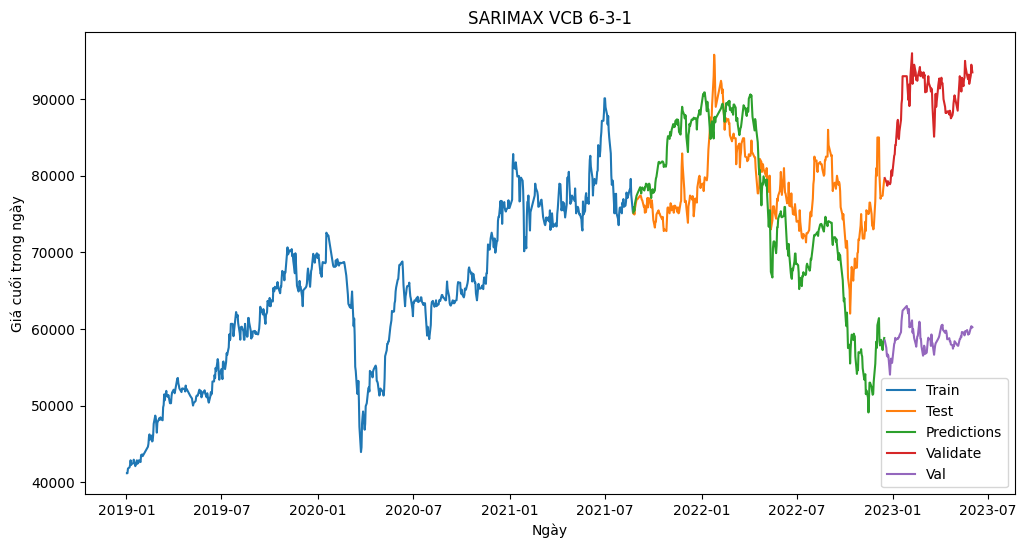

In [52]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.plot(test.index,y_pred)
plt.plot(val)
plt.plot(val.index, y_pred_val)
#plt.plot(y_next_30_days)
plt.title('SARIMAX Forecast')
plt.xlabel('Ngày')
plt.ylabel('Giá cuối trong ngày')
plt.title(title)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Val','Next 30 days'], loc='lower right')
plt.legend(['Train', 'Test', 'Predictions','Validate','Val'], loc='lower right')

In [53]:
#Các chỉ số Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [54]:
deviation(y_test,y_pred)
deviation(y_val,y_pred_val)

RMSE: 9604.00
MAPE: 10.27%
MAE: 7887.58
RMSE: 31118.16
MAPE: 34.34%
MAE: 30899.81
